# Analysis of FastMap Algorithm on Directed Graph

The content of this analysis includes:

1. Dataset - testing graph:
    - Generated random graph
    - Some directed networks from [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)
2. Variant of FastMap on directed graph:
    - Two embeddings:
        1. $h_1(i, j)=\frac{d_{ij}+d_{ji}}{2}$
        2. $h_2(i, j)=\frac{|d_{ij}-d_{ji}|}{2}$
    - Part accurate distances: a byproduct, every nodes' distances with some pivot nodes
3. Evaluation:
    - Precision of picking the bigger one of $d_{ij}$ and $d_{ji}$, using stroed distances
    - Distortion of embedding:
        1. Using real comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        2. Using prediction of comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        3. Using stroed distances to fine-tune heuristic value from embedding.
4. Experiments and results

In [11]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../heuristic/'))
sys.path.append(lib_path)

import fastmap.utils as utils
from fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff 
import fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
from random import sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate random testing graph:

1. `generate_random_digraph(n, p, low, high)`: generate a directed graph with `n` nodes, and every edge have positive weith range in `[low, high]`, it make sure the graph is strongly connected, otherwise there is a warning for increasing `p` (the probability of an directed edge exist between two nodes). Density $D = \frac{|E|}{|V|(|V|-1)}$ is also printed.

2. `distance_info(G)`: show the distribution of distances between nodes.

In [7]:
def generate_random_digraph(n, p, low, high):
    for i in range(100):
        G = nx.gnp_random_graph(n, p, directed = True)
        if nx.is_strongly_connected(G):
            break
    if nx.is_strongly_connected(G) == False:
        print("Unable to generate strongly connected graph, try increase 'p'.")
    density = float(len(G.edges()))/(n*(n-1))
    print("Density: {}".format(density))
    for (n1, n2) in G.edges():
        G[n1][n2]['weight']=random.randint(low, high)
    return G, density

def distance_info(G):
    dis = []
    for node in list(G.nodes()):
        length = nx.single_source_dijkstra_path_length(G, node)
        dis.extend(list(length.values()))
    x = list(set(dis))
    y = []
    for i in x:
        y.append(dis.count(i))
    y[0]=0
    s = sum(y)
    for i in range(len(y)):
        y[i] = float(y[i])/s
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

An example:

Density: 0.006914914914914915


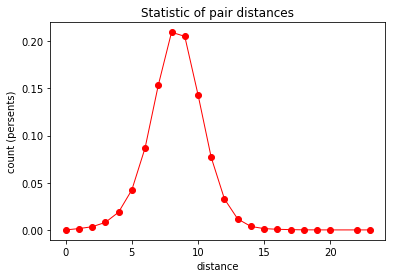

In [8]:
n = 1000
p = 0.007
low = 1
high = 5

G,_ = generate_random_digraph(n, p, low, high)
distance_info(G)

## Variant algorithms of embedding

![Figure](alg-fastmap.png)

1. `init_dis_store()`: init the data structure to store every nodes' distances to pivot nodes, the store process will be finish while doing the embedding.

2. `difastmap_average(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of average distances.

3. `difastmap_diff(G, K, epsilon, dis_store, alg='L1')`: used to get the embedding of absolute difference of distance.

An example:

In [9]:
K = 20
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
S = 1
subset = random.sample(list(G.nodes()), S)
for i in subset:
    print("Node {}:\n{}\n{}".format(i, embedding_aver[i], embedding_diff[i]))

Node 615:
[6.8515625, 6.869523113320263, 8.86154091225234, 7.447200452656599, 4.570804725755498, 7.039477015550669, 7.947599572978912, 7.54693705678538, 6.581930003238539, 7.292301424999881, 7.334134129143072, 7.641522790874139, 3.6532162142276006, 5.479246675188485, 3.5562385536760877, 5.080480419662634, 9.153607874877116, 7.3721225089425495, 5.187185181407477, 3.761223536217223]
[3.0, 2.391431320862214, 2.0418466458986084, 4.721513982627134, 2.2740423124710687, 2.9807466530928903, 2.3655505967376222, 2.819873344059838, 2.7117007952706125, 2.3214125245991517, 3.1971581046880404, 3.1583191672285813, 1.8757985049002799, 2.4770051376754214, 2.2216308634309123, 1.950087116729213, 2.2695443798824804, 2.010669581056012, 2.650940252239136, 2.871613803893437]


## Evaluation functions

`dinrmsd(G, embedding_aver, embedding_diff, dis_store, S, alg = 'L1')`: the function for evaluate the performance of the heuristic. `S` is the number of subset choosed for evaluation, and the `alg` should be set as the one used in FastMap embedding.

The output has four value:

- Precision of comparing $d_{ij}$, $d_{ji}$
- Distortion when:
    - Real comparision
    - Predicted comparision
    - Fine-tuned distance
    
Using the Normalized Root Mean Square Deviation (NRMSD):
$$\sigma = \sqrt{\frac{\sum_{1\le i < j\le S}{(d_{ij}-x_{ij})^2}}{S(S-1)}}$$
$$\bar{d}=\frac{\sum_{1\le i < j\le S}{d_{ij}}}{S(S-1)}$$

In [34]:
S = int(0.2*len(list(G.nodes())))
results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
print("\nPrecision: "+str(results[0]))
print("Distortion_real: "+ str(results[1]))
print("Distortion_pred: "+ str(results[2]))
print("Distortion_tune: "+ str(results[3]))

Analysis Process: 0.0%
Precision: 0.7421052631578947
Distortion_real: 0.2775127004423273
Distortion_pred: 0.32448200134466887
Distortion_tune: 0.25130986069654365


## Experiments

In [ ]:
# Test for real sets:
K = 40
in_directory = "../data/snap/"
files= os.listdir(in_directory)
for file in files:
    if not os.path.isdir(file) and file[0:3]=='p2p':
        print("Test for real dataset:{}".format(file))
        name = file
        G = utils.readDiGraph(in_directory+name)
        n = len(list(G.nodes()))
        density = float(len(G.edges()))/(n*(n-1))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
        embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
        S = int(0.2*len(list(G.nodes())))
        if S > 400:
            S = 400
        results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
        print("\nPrecision: "+str(results[0]))
        print("Distortion_real: "+ str(results[1]))
        print("Distortion_pred: "+ str(results[2]))
        print("Distortion_tune: "+ str(results[3]))
        results.append(density)
        print("Density: "+str(density))
        name = 'Real-'+str(name)
        all_result[name] = results

# Test K
      
n = 1000
p = 0.007
low = 1
high = 5

G,density = generate_random_digraph(n, p, low, high)
distance_info(G)

k_list = [20,25,30,35,40, 45, 50]
all_result = {}
for K in k_list:
    print("Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
    embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
    print("\nPrecision: "+str(results[0]))
    print("Distortion_real: "+ str(results[1]))
    print("Distortion_pred: "+ str(results[2]))
    print("Distortion_tune: "+ str(results[3]))
    results.append(density)
    print("Density: "+str(density))
    name = 'Ktest-'+str(K)
    all_result[name] = results

# Test for more toy sets:
K = 40
for r in range(5):
    print("Test for toy dataset, round:{}".format(r))
    G, density = generate_random_digraph(n, p, low, high)
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding_aver = difastmap_average(G, K, epsilon, dis_store, alg)
    embedding_diff = difastmap_diff(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    results = analyse.dinrmsd(G, embedding_aver, embedding_diff,dis_store, S, alg)
    print("\nPrecision: "+str(results[0]))
    print("Distortion_real: "+ str(results[1]))
    print("Distortion_pred: "+ str(results[2]))
    print("Distortion_tune: "+ str(results[3]))
    results.append(density)
    print("Density: "+str(density))
    name = 'Round-'+str(r)
    all_result[name] = results

## Test multiprocessing on analysis

In [22]:
def meta_calculation(node_1):
    global G, embedding_aver, embedding_diff, dis_store, alg, subset
    embcomb_1 = np.array(embedding_aver[node_1])
    embdiff_1 = np.array(embedding_diff[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    cnt_right = 0
    real_sigma = 0
    pred_sigma = 0
    tune_sigma = 0
    ave_d = 0
    for j in range(S):
        node_2 = subset[j]
        if node_1 == node_2:
            continue
        embcomb_2 = np.array(embedding_aver[node_2])
        embdiff_2 = np.array(embedding_diff[node_2])
        distance = length[node_2]
        if alg == 'L1':
            embdis_comb = np.sum(np.abs(embcomb_1-embcomb_2))
            embdis_diff = np.sum(np.abs(embdiff_1-embdiff_2))
        elif alg == 'L2':
            embdis_comb = math.sqrt(np.dot(embcomb_1-embcomb_2, embcomb_1-embcomb_2))
            embdis_diff = math.sqrt(np.dot(embdiff_1-embdiff_2, embdiff_1-embdiff_2))
        distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
        maxdis = embdis_comb + embdis_diff
        mindis = embdis_comb - embdis_diff
        cmp_res, cmp_p, tune_embdis = analyse.compare_DiEdge(dis_store['pivots'], dis_store[node_1], dis_store[node_2], maxdis, mindis)
        if distance > distance_reverse:
            real_embdis = maxdis
            if cmp_p == 0:
                cnt_right += 1
        elif distance == distance_reverse:
            real_embdis = embdis_comb
            cnt_right += 1
        else:
            real_embdis = mindis
            if cmp_p == 2:
                cnt_right += 1
        if cmp_p == 0:
            pred_embdis = maxdis
        elif cmp_p == 1:
            pred_embdis = embdis_comb
        else:
            pred_embdis = mindis
        real_sigma += (distance-real_embdis)*(distance-real_embdis)
        pred_sigma += (distance-pred_embdis)*(distance-pred_embdis)
        tune_sigma += (distance-tune_embdis)*(distance-tune_embdis)
        ave_d += distance
    return [real_sigma, pred_sigma, tune_sigma, ave_d, cnt_right]

def dinrmsd_mp(G, embedding_aver, embedding_diff, dis_store, subset, alg = 'L1'):
    #if S<=1:
    #    print("S should bigger than 1")
    #    exit
    #subset = sample(list(G.nodes()), S)
    input_set = list(subset)
    real_sigma = 0
    pred_sigma = 0
    tune_sigma = 0
    ave_d = 0
    cnt_right = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_calculation, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    real_sigma, pred_sigma, tune_sigma, ave_d, cnt_right = np.sum(pool_outputs, 0)
    base = S*(S-1)
    real_sigma = math.sqrt(float(real_sigma)/base)
    pred_sigma = math.sqrt(float(pred_sigma)/base)
    tune_sigma = math.sqrt(float(tune_sigma)/base)
    ave_d = float(ave_d)/base
    precision = float(cnt_right)/base
    distorsion_real = float(real_sigma)/ave_d
    distorsion_pred = float(pred_sigma)/ave_d
    distorsion_tune = float(tune_sigma)/ave_d
    return precision, distorsion_real, distorsion_pred, distorsion_tune


In [23]:
S = int(0.2*len(list(G.nodes())))
subset = sample(list(G.nodes()), S)
results = dinrmsd_mp(G, embedding_aver, embedding_diff,dis_store, subset, alg)
print("\nPrecision: "+str(results[0]))
print("Distortion_real: "+ str(results[1]))
print("Distortion_pred: "+ str(results[2]))
print("Distortion_tune: "+ str(results[3]))

Pool size: 8

Precision: 0.7096984924623115
Distortion_real: 0.2968770082012998
Distortion_pred: 0.35323881424845693
Distortion_tune: 0.25758484804706344
